## Correlated Randomized Benchmarking
---

## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. If we run simultaneous RB we can look at the decay of correlated Z-Pauli's to extract the weight and locality of errors (see paper XXX).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module to run correlated RB. This particular example shows how to run single qubit simultaneous randomized benchmarking on 5 qubits. 

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

#Import the Fitter Functions
from qiskit.ignis.verification.randomized_benchmarking import CorrelatedRBFitter

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 4 qubits Q0,Q1,Q2,Q3. 
We are running 1Q RB (on each qubit) simultaneously, 

In [2]:
##### Number of qubits. There are 4 qubits: Q0,Q1,Q2,Q3.
nQ = 4
#Number of seeds (random sequences)
nseeds = 20 #set to 20 for testing
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = list(np.arange(1,1000,50))

#1Q RB on Q0-3 simultaneously
rb_pattern = [[0],[1],[2],[3]]
basis_gates = ['u1', 'u2', 'u3', 'cx']

## create the noise model
we will try to simulate the device noise - we will use thermal relaxation .

and add a non local error with a matrix of ZZ error between qubits 1 and 2

In [3]:
#load the backend
backend = qiskit.Aer.get_backend('qasm_simulator')

# create noise model
# create ZZ noise between qubits 1 and 2
noise_model = NoiseModel()

zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = np.exp(0.5j * (np.pi / 5))
error = coherent_unitary_error(zz_unitary)

noise_model.add_nonlocal_quantum_error(error, basis_gates, [1], [1, 2])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 1])

# Add T1/T2 noise to the simulation
t_1 = 10
t_2 = 20
gate1q = 0.1
gate2q = 0.5
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, gate1q), 'u2')
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, 2 * gate1q), 'u3')
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_error(t_1, t_2, gate2q).tensor(thermal_relaxation_error(t_1, t_2, gate2q)), 'cx')

### Create and run the measurement calibration
Measurement correction is needed because we want to measure the correlations during RB independent of any measurement correlations

In [4]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(4)
qubit_list = []
for i in rb_pattern:
    for j in i:
        qubit_list.append(j)
print(qubit_list)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

[0, 1, 2, 3]


In [5]:
shots = 1024
meas_calibs_trans = qiskit.compiler.transpile(meas_calibs, 
                                              backend=backend, 
                                              basis_gates=basis_gates, optimization_level=0)
qobj = qiskit.compiler.assemble(meas_calibs_trans, shots=shots)
job = backend.run(qobj)

In [6]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(job.result(), state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [7]:
# Get the filter object
meas_filter = meas_fitter.filter

## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict:** Option dictionary back out with default options appended.

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [9]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
# rb_opts['rand_seed'] = 0
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence

In [10]:
print(rb_circs[0][0])

      ┌───┐  ░  ┌───┐       ┌─┐                
qr_0: ┤ H ├──░──┤ H ├───────┤M├────────────────
      ├───┤┌───┐└─░─┘ ┌───┐ └╥┘┌───┐     ┌─┐   
qr_1: ┤ X ├┤ H ├──░───┤ H ├──╫─┤ X ├─────┤M├───
      ├───┤└─░─┘┌───┐ └───┘  ║ └┬─┬┘     └╥┘   
qr_2: ┤ Y ├──░──┤ Y ├────────╫──┤M├───────╫────
      ├───┤┌───┐└─░─┘┌─────┐ ║  └╥┘ ┌───┐ ║ ┌─┐
qr_3: ┤ Y ├┤ S ├──░──┤ SDG ├─╫───╫──┤ Y ├─╫─┤M├
      └───┘└───┘  ░  └─────┘ ║   ║  └───┘ ║ └╥┘
cr: 4/═══════════════════════╩═══╩════════╩══╩═
                             0   2        1  3 


## Execute RB Circuits

We can execute the RB sequences using IBMQ provider, 
and obtain a list of results **result_list**.

In [11]:
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
# run the noisy simulation (with fixed seed)
results = []
for circ_ind, circuit in enumerate(rb_circs):
    results.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
finished seed 5
finished seed 6
finished seed 7
finished seed 8
finished seed 9
finished seed 10
finished seed 11
finished seed 12
finished seed 13
finished seed 14
finished seed 15
finished seed 16
finished seed 17
finished seed 18
finished seed 19
Finished Running


## Get statistics about the survival probabilities

The results in **results_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

We fit to each of the correlators.

### Fit the RB data to get the decay parameters "alpha"

In [12]:
#correct results
result_corr = []
for result in results:
    result_corr.append(meas_filter.apply(result))

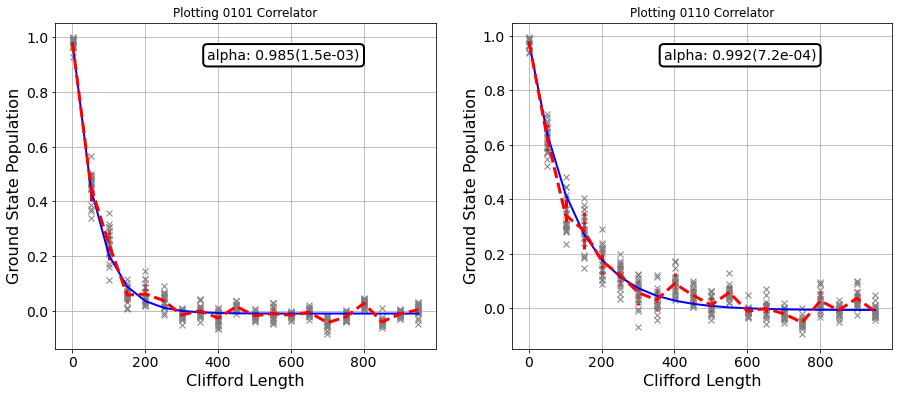

In [13]:
rbfit = CorrelatedRBFitter(None, xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_corr):
    
    # Add another seed to the data
    if seed_num>-1:
        rbfit.add_data([data],rerun_fit=False)
        
rbfit.calc_data()
rbfit.calc_statistics()
rbfit.fit_data()

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(4,6)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)


In [14]:
#These are the decay parameters from the fit
rbfit.fit_alphas

{'0001': 0.9935386282003672,
 '0010': 0.9930985414467265,
 '0011': 0.9863250816830144,
 '0100': 0.9905363147300796,
 '0101': 0.9847535401729314,
 '0110': 0.9916929351035559,
 '0111': 0.9840667280557828,
 '1000': 0.9940937506743049,
 '1001': 0.9868063987875513,
 '1010': 0.9875095295305653,
 '1011': 0.9795746104162617,
 '1100': 0.9838400346648403,
 '1101': 0.9793864308576171,
 '1110': 0.986537901926401,
 '1111': 0.9783313067201087}

In [15]:
rbfit.fit_alphas_to_epsilon()

3.031844392272917e-06

In [16]:
rbfit.fit_epsilon

{'0001': [0.006595924024475173, 0.0006431821104391784],
 '0010': [2.2511301325295078e-09, 0.0006495914306089177],
 '0011': [3.858102121870141e-10, 0.0009156363224750798],
 '0100': [0.0014004480080241398, 0.0006482276576193511],
 '0101': [0.0004025823563659487, 0.0009145357468929148],
 '0110': [0.006861729948119273, 0.0009101610229553026],
 '0111': [8.496694929202212e-08, 0.001291659339659207],
 '1000': [0.005809637948991526, 0.0006439442861482709],
 '1001': [3.467565062803335e-11, 0.0009129804426811952],
 '1010': [9.423193341874148e-07, 0.0009159952843253994],
 '1011': [4.633937956301952e-08, 0.0012911489644300883],
 '1100': [0.0003121424511525805, 0.0009149985772373403],
 '1101': [2.2514126861538803e-08, 0.001290016803486784],
 '1110': [6.944105664857818e-06, 0.0012921857866239372],
 '1111': [2.029744932643574e-07, 0.0017648783349981088]}

In [17]:
#These are the calculated decay parameters given the depolarizing probabilities 
#that the fitter returned
rbfit._calc_alphas([rbfit.fit_epsilon[i][0] for i in rbfit._subsystems])

array([0.99300379, 0.9931301 , 0.98618229, 0.99103154, 0.98449473,
       0.99103056, 0.9844938 , 0.99387192, 0.98691886, 0.98705216,
       0.98014689, 0.98527303, 0.97877425, 0.98527303, 0.97877424])

Text(0.5, 1.0, 'Qubits [0, 1, 2, 3] on Backend qasm_simulator')

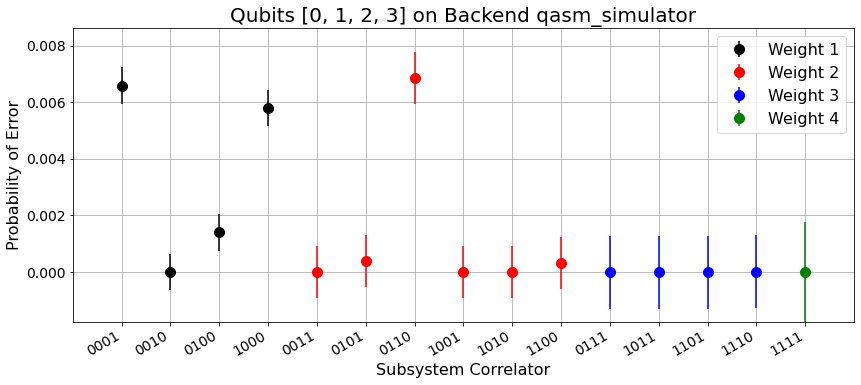

In [18]:
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)

We can see that the correlator '0110' has high value, like expected.

### for comparison - run with different noise model.
set the ZZ error only between qubits 0 and 3.

the rest will be the same - same RB circuits and same thermal error.

this way we can see the that the changes in the epsilon map correspond to the changes in the noise

In [19]:
noise_model2 = NoiseModel()

noise_model2.add_nonlocal_quantum_error(error, basis_gates, [0], [0, 3])
noise_model2.add_nonlocal_quantum_error(error, basis_gates, [3], [3, 0])


# Add T1/T2 noise to the simulation
t_1 = 10
t_2 = 20
gate1q = 0.1
gate2q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, gate1q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, 2 * gate1q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t_1, t_2, gate2q).tensor(thermal_relaxation_error(t_1, t_2, gate2q)), 'cx')

In [20]:
results2 = []
for circ_ind, circuit in enumerate(rb_circs):
    results2.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model2,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
finished seed 5
finished seed 6
finished seed 7
finished seed 8
finished seed 9
finished seed 10
finished seed 11
finished seed 12
finished seed 13
finished seed 14
finished seed 15
finished seed 16
finished seed 17
finished seed 18
finished seed 19
Finished Running


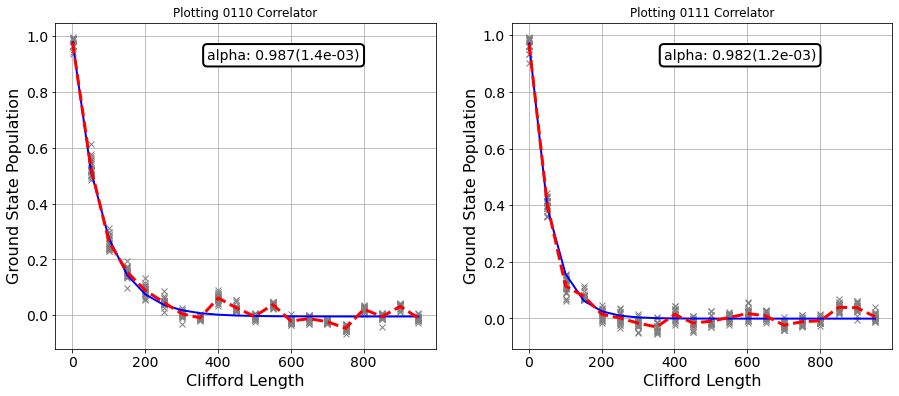

In [21]:
#correct results
result_corr2 = []
for result in results2:
    result_corr2.append(meas_filter.apply(result))

rbfit2 = CorrelatedRBFitter(result_corr2, xdata, rb_opts['rb_pattern'])

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit2.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

Text(0.5, 1.0, 'Qubits [0, 1, 2, 3] on Backend qasm_simulator')

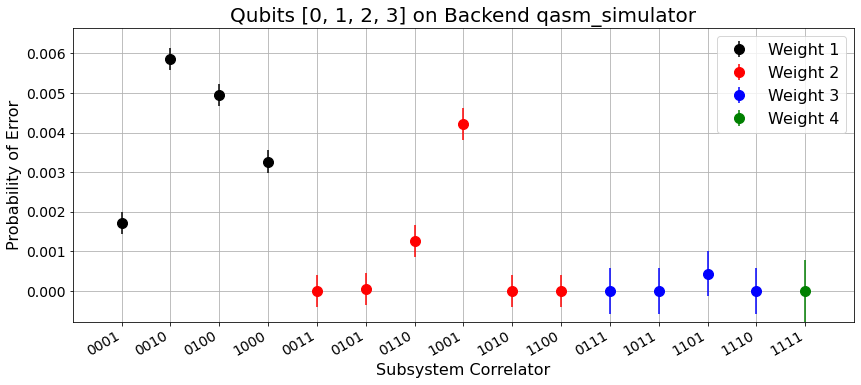

In [22]:
rbfit2.fit_alphas
rbfit2.fit_alphas_to_epsilon()
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit2.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)

### Check different pattern
with patterns with different subsystem sizes there seems to have a lot of statistical correlations. the fitter finds high "crosstalk" errors even when no crosstalk noise injected at all. still checking if it is bug, or there is really a high correlations within multi-qubit patterns.

In [23]:
#Number of seeds (random sequences)
nseeds = 5 #set to 20 for testing
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs2 = list(np.arange(1,600,50))

#1Q RB on Q0-3 simultaneously
rb_pattern2 = [[0,1],[2, 3],[4]]

rb_opts2 = {}
rb_opts2['length_vector'] = nCliffs2
rb_opts2['nseeds'] = nseeds
rb_opts2['rb_pattern'] = rb_pattern2
# rb_opts['rand_seed'] = 0
rb_circs2, xdata2 = rb.randomized_benchmarking_seq(**rb_opts2)

In [32]:
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

# create noise model
noise_model3 = NoiseModel()

p1Q = 0.0005
p2Q = 0.005

noise_model3.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model3.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model3.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

In [33]:
# run the noisy simulation (with fixed seed)
# use the same noise as the first run
results3 = []
for circ_ind, circuit in enumerate(rb_circs2):
    results3.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model3,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
Finished Running


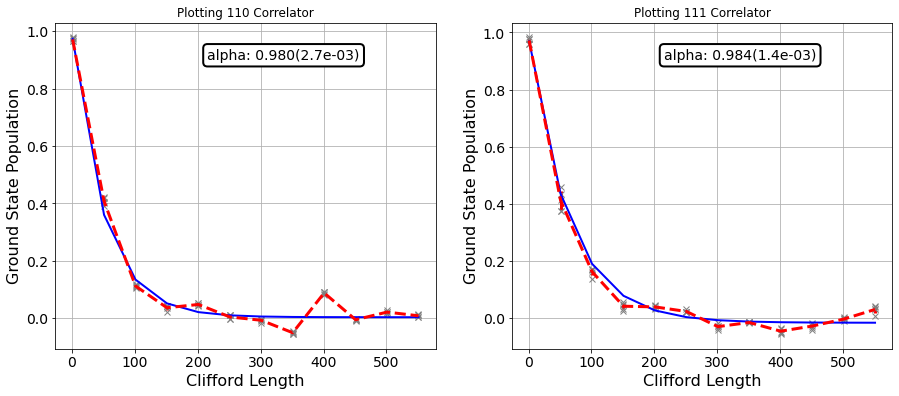

In [34]:
rbfit3 = CorrelatedRBFitter(results3, xdata2, rb_opts2['rb_pattern'])

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit3.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

Text(0.5, 1.0, 'Qubits [[0, 1], [2, 3], [4]] on Backend qasm_simulator')

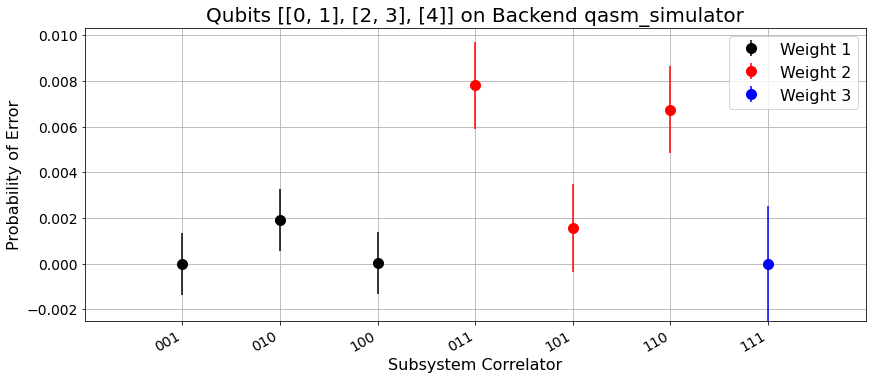

In [35]:
rbfit3.fit_alphas
rbfit3.fit_alphas_to_epsilon()
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit3.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(rb_opts2['rb_pattern']),backend.name()), fontsize=20)

when all the subsystems are the same size, these correlations are smaller (but still not negligible)

In [36]:
rb_pattern3 = [[0,1],[2, 3],[4,5]]
rb_opts3 = {}
rb_opts3['length_vector'] = nCliffs2
rb_opts3['nseeds'] = nseeds
rb_opts3['rb_pattern'] = rb_pattern3
# rb_opts['rand_seed'] = 0
rb_circs3, xdata3 = rb.randomized_benchmarking_seq(**rb_opts3)

In [37]:
# run the noisy simulation (with fixed seed)
# use the same noise as the first run
results4 = []
for circ_ind, circuit in enumerate(rb_circs3):
    results4.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model3,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
Finished Running


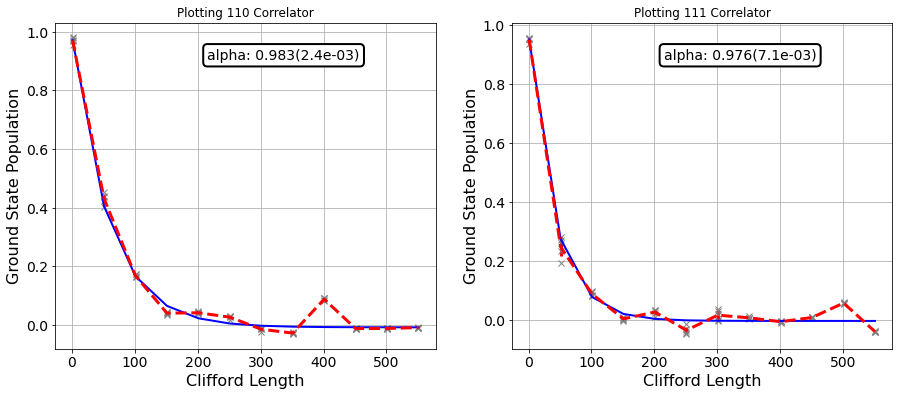

In [38]:
rbfit4 = CorrelatedRBFitter(results4, xdata3, rb_opts3['rb_pattern'])

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit4.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

Text(0.5, 1.0, 'Qubits [[0, 1], [2, 3], [4, 5]] on Backend qasm_simulator')

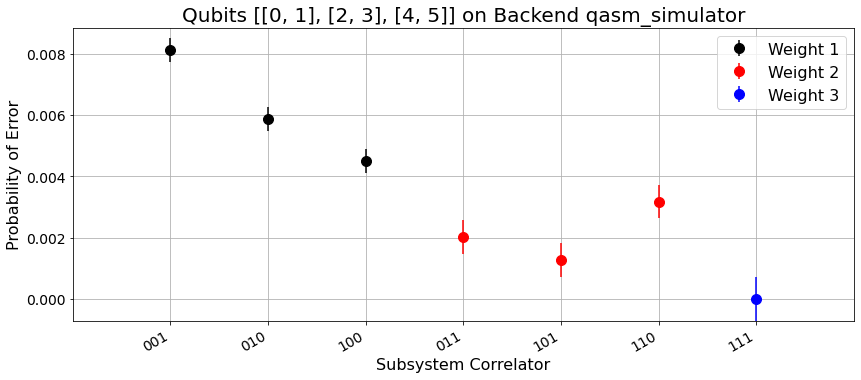

In [39]:
rbfit4.fit_alphas
rbfit4.fit_alphas_to_epsilon()
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit4.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(rb_opts3['rb_pattern']),backend.name()), fontsize=20)